In [ ]:
# conda/pip install pycircstat

In [7]:
import sys
import os
import math
import random
import pickle

import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
from scipy import stats,io
import pycircstat
from scipy.ndimage import gaussian_filter1d


# Functions

In [20]:


sys.path.append('/Users/jasperhvdm/Dropbox (Attention Group)/Attention Group Team Folder/Jasper/lab_meeting_Feb/temp_dec')
from decoding_functions import *
from least_squares_fit_cos import *



In [5]:
# simple function to plot a time course 

def tsplot(x,y,color='k',smooth=True,chance=0):
    """Plot line with chance hline"""
    #figure
    fig = plt.figure(figsize=(6,6))
    ax = plt.subplot(1,1,1)
    #plot line
    ax.plot(x, y,color='k',linewidth=1.5)
    ax.plot(x, gaussian_filter1d(y,5),color='red',linewidth=2)

    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)
    ax.hlines(chance, min(x), max(x), color='gray', linestyle='dashed')
    
    return ax


# Load in the data of example subject

In [81]:
#searchlight neighbours
electrode_SL = io.loadmat('/Users/jasperhvdm/Documents/DPhil/PROJECTS/EXP8_UpdProtec/data/Channel_selection/neighbours.mat')

# load data
path = '/Users/jasperhvdm/Dropbox (Attention Group)/Attention Group Team Folder/Jasper/lab_meeting_Feb/'
with open (path + 'data_S13_bias_decoding_UpPro', 'rb') as fp:
    [stimulus, prev_stim, wm_load, cue, X, time, stimulus_nr] = pickle.load(fp)

# Run classification on MEG time series

In [23]:
# run decoding
# data as trials x features x time

# subselect trials
X = X[(stimulus_nr == 1) | (stimulus_nr == 2), :, :]
# stimuli
nr_bins = 10
bins = np.arange(-math.pi-0.000001, math.pi, 2*math.pi/nr_bins)
y = np.digitize(pycircstat.cdiff(stimulus, 0), bins) 
   
# check between -400 ms and 900 ms
time_lim = [-.4, .9]
X_all = X[:,:,(time >= time_lim[0]) & (time <= time_lim[1]) ] #select time points ( >-.2 and <1.0)
time_ = time[(time >= time_lim[0]) & (time <= time_lim[1]) ] #adjust the time vector
    
        
evidence = temporal_decoding(X_all, y, time_,
                               n_bins = nr_bins,
                               size_window = 30,
                               n_folds = 10,
                               classifier = 'LDA',
                               use_pca = True,
                               pca_components = .9,
                               temporal_dynamics = True,
                               demean='trial_window') 



In [ ]:
# output_channel_evidence = np.zeros((306,34))


# subselect trials
X = X[(stimulus_nr == 1) | (stimulus_nr == 2), :, :]
# stimuli
nr_bins = 10
bins = np.arange(-math.pi-0.000001, math.pi, 2*math.pi/nr_bins)
y = np.digitize(pycircstat.cdiff(stimulus, 0), bins) 
   
# check between -400 ms and 900 ms
time_lim = [.15, .32]
X_all = X[:,:,(time >= time_lim[0]) & (time <= time_lim[1]) ] #select time points ( >-.2 and <1.0)
time_ = time[(time >= time_lim[0]) & (time <= time_lim[1]) ] #adjust the time vector
    
    
for ch in range(100,306):
    print(ch)
    X_chan = X_all[:,electrode_SL['neighb'][:,ch]==True,:]
    
    evidence = temporal_decoding(X_chan, y, time_,
                                   n_bins = nr_bins,
                                   size_window = 30,
                                   n_folds = 10,
                                   classifier = 'LDA',
                                   use_pca = True,
                                   pca_components = .95,
                                   temporal_dynamics = True,
                                   demean='window') 
    
    # topoplot averaged over multiple time points or get topo for every tp.
    print('compute_evidence')
    evidence = cos_convolve(evidence)
    output_channel_evidence[ch,:] = evidence['cos_convolved']

100
compute_evidence
101
compute_evidence
102
compute_evidence
103
compute_evidence
104
compute_evidence
105
compute_evidence
106
compute_evidence
107
compute_evidence
108
compute_evidence
109
compute_evidence
110
compute_evidence
111
compute_evidence
112
compute_evidence
113
compute_evidence
114
compute_evidence
115
compute_evidence
116
compute_evidence
117
compute_evidence
118
compute_evidence
119
compute_evidence
120
compute_evidence
121
compute_evidence
122
compute_evidence
123
compute_evidence
124
compute_evidence
125
compute_evidence
126
compute_evidence
127
compute_evidence
128
compute_evidence
129
compute_evidence
130
compute_evidence
131
compute_evidence
132
compute_evidence
133
compute_evidence
134
compute_evidence
135
compute_evidence
136
compute_evidence
137
compute_evidence
138
compute_evidence
139
compute_evidence
140
compute_evidence
141
compute_evidence
142
compute_evidence
143
compute_evidence
144
compute_evidence
145
compute_evidence
146
compute_evidence
147
compute_e

In [77]:
output_channel_evidence.shape

(306, 34)

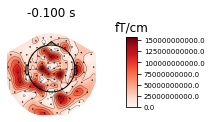

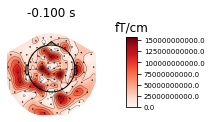

In [80]:
# Nr of trials and nr of subjects
# with open('/Users/jasperhvdm/Documents/DPhil/Projects/EXP8_UpdProtec/scripts/MEG_topo_struct.pkl', 'rb') as f:  
#     [epochs] = pickle.load(f)
# evoked = epochs.average()

evoked.data[:,0] = output_channel_evidence[:,32:33].mean(1)

times = evoked.times
evoked.plot_topomap(times[0:1], ch_type='grad', time_unit='s')

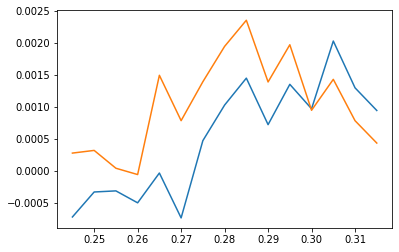

In [63]:
plt.plot(time_,output_channel_evidence[0,:].T)
plt.plot(time_,output_channel_evidence[1,:].T)

# Output data

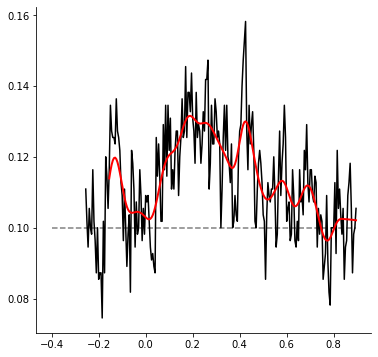

In [24]:
tsplot(time_,evidence['accuracy'],chance=.1)

# Cos convolved evidence

In [30]:
# this function will compute the (avg.) cos-convolved evidence per trial
# and adds this to the dictionary
evidence = cos_convolve(evidence)

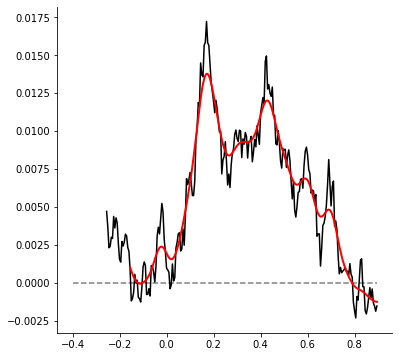

In [78]:
tsplot(time_,evidence['cos_convolved'],chance=0)

Text(0.5, 1.0, 'mean cos conv evidence')

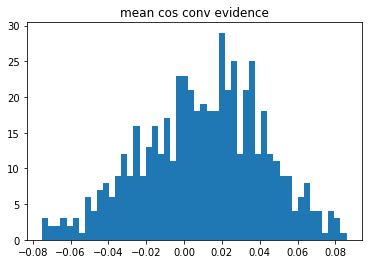

In [51]:
plt.hist(evidence['single_trial_cosine_fit'][:,(time_>=.2) & (time_<=.5)].mean(1),50)
plt.title('mean cos conv evidence')

# Fit cosine tuning curve to data

In [60]:
def decoding_evidence_shift(evidence, y, distractor,
                             nbin = 100, min_lim = 25, max_lim = 50):
    
    """ shifts in tuning curve based on target and distractor distance. 

    """
    
    if isinstance(evidence, dict): tuning = evidence['single_trial_ev_centered']
    else: tuning = evidence
    
    tb = np.zeros((nbin, tuning.shape[1], tuning.shape[2]))

    #get the sizes
    y_diff = pycircstat.cdiff(distractor, y) 

    bins = np.arange(-math.pi, math.pi, 2*math.pi/nbin)
    y_diff_binned = np.digitize(y_diff, bins) 
    for i in range(1, nbin+1):
        tb[i-1, :, :] = evidence['single_trial_ev_centered'][y_diff_binned == i, :, :].mean(0)
    
    tuning_binned = np.zeros((2, tuning.shape[1], tuning.shape[2]))
    x_bins = np.arange(-math.pi, math.pi, 2*math.pi/nbin) + 1/nbin*math.pi
    
    tuning_binned[0, :, :] = tb[(x_bins >= -max_lim/90*np.pi) & (x_bins <= -min_lim/90*np.pi) ,: ,:].mean(0)
    tuning_binned[1, :, :] = tb[(x_bins <= max_lim/90*np.pi) & (x_bins >= min_lim/90*np.pi), :, :].mean(0)
        
    output_biasfit = least_squares_fit_cos(tuning_binned, 1)  

        
    return output_biasfit, tuning_binned

Text(0, 0.5, 'prev_stimulus orientation')

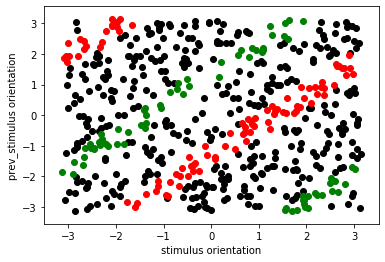

In [72]:
#
min_lim = 25
max_lim = 50

# not selected orientations
y_diff = pycircstat.cdiff(prev_stim, stimulus) 
plt.scatter(stimulus[y_diff < -max_lim/90*np.pi],prev_stim[y_diff < -max_lim/90*np.pi],color='k')
plt.scatter(stimulus[y_diff > max_lim/90*np.pi],prev_stim[y_diff > max_lim/90*np.pi],color='k')
plt.scatter(stimulus[(y_diff > -min_lim/90*np.pi) & (y_diff < min_lim/90*np.pi)],prev_stim[(y_diff > -min_lim/90*np.pi) & (y_diff < min_lim/90*np.pi)],color='k')

#selected orientations
plt.scatter(stimulus[(y_diff <= max_lim/90*np.pi) & (y_diff >= min_lim/90*np.pi)],prev_stim[(y_diff <= max_lim/90*np.pi) & (y_diff >= min_lim/90*np.pi)],color='g')
plt.scatter(stimulus[(y_diff >= -max_lim/90*np.pi) & (y_diff <= -min_lim/90*np.pi)],prev_stim[(y_diff >= -max_lim/90*np.pi) & (y_diff <= -min_lim/90*np.pi)],color='r')
plt.xlabel('stimulus orientation')
plt.ylabel('prev_stimulus orientation')




In [53]:
output_bias,distractor_tuning = decoding_evidence_shift(evidence, stimulus, prev_stim, 
                                                                          min_lim = 25, max_lim = 50)

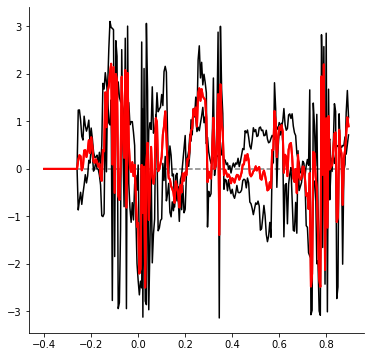

In [79]:
tsplot(time_,output_bias['phase'])
